# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [1]:
!pip install -qq catboost
!pip install -qq hyperopt

In [2]:
# Подключим все необходимые библиотеки 
import os
import math
import time
import itertools 
import urllib.request
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost
import lightgbm as lgb
import matplotlib.pyplot as plt
from pathlib import Path
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.metrics import *
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

import random
random_state=42
random.seed(random_state)
np.random.seed(random_state)

import warnings
warnings.filterwarnings('ignore')
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
import timeit
from functools import lru_cache
import tensorflow as tf


<div class="alert alert-info">
<font size="4">🍕<b> Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Стандарт PEP8 рекомендует импорты делать не в каждой строке отдельный, а группировать их по сабмодулю, из которого делается импорт.

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
А вот задать сразу рандом - отличный ход

In [3]:
# Проверяем количество доступных GPU
if tf.test.is_gpu_available():
    print("GPU is available.")
else:
    print("GPU is not available =(")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is not available =(


2023-06-18 08:51:52.865353: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<div class="alert alert-info">
<font size="4">🍕<b> Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Зачем тебе в целом проверка доступности GPU, если нейросеть ты в проекте не обучаешь? Или потому и не обучаешь, что GPU нет?)

второй вариант

In [4]:
# функция определения выбросов по правилу 3 сигм
def outlier(data):
    data_mean, data_std = np.mean(data), np.std(data)
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    outliers = [x for x in data if x < lower or x > upper]
    outliers_removed = [x for x in data if x >= lower and x <= upper]
    return len(outliers)

#  функция для описания статистик: 
def describe_full_stat(df, target_name=""):
    data_describe = df.describe().T
    df_numeric = df._get_numeric_data()
    if target_name in df.columns:
        corr_with_target=df_numeric.drop(target_name, axis=1).apply(lambda x: x.corr(df_numeric[target_name]))
        data_describe['corr_with_target']=corr_with_target
    dtype_df = df_numeric.dtypes
    data_describe['dtypes'] = dtype_df
    data_null = df_numeric.isnull().sum()/len(df) * 100
    data_describe['Missing %'] = data_null
    Cardinality = df_numeric.apply(pd.Series.nunique)
    data_describe['Cardinality'] = Cardinality
    df_skew = df_numeric.skew(axis=0, skipna=True)
    data_describe['Skew'] = df_skew
    data_describe['outliers']=[outlier(df_numeric[col]) for col in df_numeric.columns]
    data_describe['kurtosis']=df_numeric.kurtosis()
    return data_describe

#  функция для нулевых и пропущенных значений: 
def missing_zero_values_table(df):
    zero_val = (df == 0.00).astype(int).sum(axis=0)
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mz_table = pd.concat([zero_val, mis_val, mis_val_percent], axis=1)
    mz_table = mz_table.rename(
        columns={0: 'Zero Values', 1: 'Missing Values', 2: '% of Total Values'})
    mz_table['Total Zero Missing Values'] = mz_table['Zero Values'] + mz_table['Missing Values']
    mz_table['% Total Zero Missing Values'] = 100 * mz_table['Total Zero Missing Values'] / len(df)
    mz_table['Data Type'] = df.dtypes
    mz_table = mz_table[
        mz_table.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
    print("Your selected dataframe has " + str(df.shape[1]) + " columns and " + str(df.shape[0]) + " Rows.\n"
                                                                                                   "There are " + str(
        mz_table.shape[0]) +
          " columns that have missing values.")

    return mz_table

def corr_diagram(x):
    plt.figure(figsize=(20, 15), dpi=80)
    sns.heatmap(x.corr(), xticklabels=x.corr().columns, yticklabels=x.corr().columns, cmap='RdYlGn', center=0,
                annot=True)
    plt.title('Диаграмма корреляции', fontsize=22)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()


In [5]:
df = pd.read_csv('/datasets/autos.csv')



<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера V2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
👌

In [6]:
# КОД РЕВЬЮЕРА
#set(target)

In [7]:
#Посмотрим на количество пустых значений в датасете
missing_zero_values_table(df)


Your selected dataframe has 16 columns and 354369 Rows.
There are 5 columns that have missing values.


,Zero Values,Missing Values,% of Total Values,Total Zero Missing Values,% Total Zero Missing Values,Data Type
Repaired,0,71154,20.1,71154,20.1,object
VehicleType,0,37490,10.6,37490,10.6,object
FuelType,0,32895,9.3,32895,9.3,object
Gearbox,0,19833,5.6,19833,5.6,object
Model,0,19705,5.6,19705,5.6,object


In [8]:
#Изучим первоначальную инфмормацию о датасете методом info и describe
display(df.info())
display(df.describe())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [9]:
#Посмотрим на количество дубликатов в датасете
df.duplicated().sum()


4

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
Очистка дубликатов - важный шаг EDA

<div class="alert alert-warning">
<font size="4"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
Но делать его стоит в конце анализа, поскольку количество дубликатов внезапно за время манипуляция с данными может стать больше.

UPD: увидел в ходе дальнейшей проверки, что так и сделал в конце, молодец!
    </font>
</div>

In [10]:
#Удалим столбцы которые нам не понадобятся
df=df.drop(['DateCrawled','DateCreated','PostalCode','LastSeen','NumberOfPictures'], axis=1)
df.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
Неинформативные признаки определены верно

In [11]:
# пустые значения в Repaired заменим на 0, так как по умолчанию, 
#скорее всего пользователи заполнявшие форму "Чинилась ли машина", просто не заполняли, если не чинилась. 
df['Repaired'] = df['Repaired'].fillna(0)
df["Repaired"] = (df["Repaired"] == 'yes').astype('int')
#df["Gearbox"] = (df["Gearbox"] == "auto").astype("int")


<div class="alert alert-info">
<font size="4">🍕<b> Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Заполнить признак ремонта значением "нет", допустим, не лишено логики, как минимум, это мода значений признака.

<div class="alert alert-warning">
<font size="4"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
А вот почему по умолчанию тип КПП - автомат - загадка. Автомобилей на ручнике намного больше в датасете. Выглядит всё равно что заполнить тип двигателя "элетрический", хотя таких меньшинство.
    </font>
</div>

In [12]:
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,0
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,1
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,0
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,0
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,0
...,...,...,...,...,...,...,...,...,...,...,...
354364,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,1
354365,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,0
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,0
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,0


In [13]:
df.isna().sum()

Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired                 0
dtype: int64

In [14]:
# def impute_value(in_df, features, target):
#     encoders=dict()
#     df = in_df.copy()
#     for col in df[features].select_dtypes('object').columns:
#         df.loc[df[col].isna(), col] = "None"
#         le = LabelEncoder()
#         df[col] = le.fit_transform(df[col])
#         encoders[col] = le 
#     features = list(set(df.columns)-set([target]))
#     train_df = df[~df[target].isna()]
#     test_df = df[df[target].isna()]
#     let = LabelEncoder()
#     y_train = let.fit_transform(train_df[target])
#     y_train = train_df[target].values
#     X_train, X_test = train_df[features].values, test_df[features].values
#     if len(X_test)==0:
#         return in_df
#     model = DecisionTreeClassifier().fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     df.loc[df[target].isna(), target] = y_pred
#     in_df[target] = df[target]
#     return in_df

1. Функция принимает три аргумента: входной DataFrame in_df, список признаков features и целевую переменную target.

2. Сначала создается копия входного DataFrame, чтобы не изменять исходные данные.

3. Затем функция проходит через все столбцы в DataFrame, выбирая те, которые имеют тип данных 'object'. Это обычно категориальные переменные. Если в столбце присутствуют пропущенные значения (NaN), они заменяются на строку "None".

4. Каждый из этих столбцов преобразуется с помощью LabelEncoder из sklearn, который кодирует категориальные признаки числовыми значениями. Словарь encoders хранит эти кодировщики для каждого столбца.

5. После этого входной DataFrame разбивается на обучающий и тестовый наборы. Обучающий набор содержит все строки, где целевой признак не равен NaN, а тестовый набор содержит строки, где целевой признак равен NaN.

6. Целевой признак обучающего набора преобразуется в числовые значения с помощью LabelEncoder.

7. Затем функция обучает модель DecisionTreeClassifier на обучающем наборе данных и предсказывает значения целевого признака для тестового набора.

8. Предсказанные значения используются для заполнения пропущенных значений в исходном DataFrame.

9. В конце исходный DataFrame возвращается с заполненными пропущенными значениями.

P.S. Функция impute_value применяет методы машинного обучения для заполнения пропущенных значений, вместо того чтобы просто заполнить их средним, медианой или наиболее часто встречающимся значением. Это может быть более эффективным подходом, особенно когда есть корреляция между пропущенными значениями и другими признаками.






<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера V2</b></font>
    <br /> 
    <font size="3", color = "black">
<br /> 
Использование модели для заполнения пропусков - в целом идея классная

In [15]:
# from sklearn.preprocessing import OrdinalEncoder, StandardScaler
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.impute import SimpleImputer
# from sklearn.pipeline import make_pipeline

# def impute_value(in_df, features, target):
#     # Копируем исходный датафрейм
#     df = in_df.copy()
    
#     # Разделяем датафрейм на тренировочный и тестовый
#     train_df = df[~df[target].isna()]
#     test_df = df[df[target].isna()]
    
#     # Проверяем, есть ли в тестовом датасете данные. Если нет, то возвращаем исходный датафрейм
#     if len(test_df)==0:
#         return in_df
    
#     # Создаем список признаков
#     features = list(set(df.columns) - set([target]))
    
#     # Создаем объекты для обработки данных
#     ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
#     scaler = StandardScaler()
#     classifier = DecisionTreeClassifier()
    
#     # Создаем конвейер для обработки данных
#     pipeline = make_pipeline(ordinal_encoder, scaler, classifier)
    
#     # Обучаем модель на тренировочных данных
#     X_train = train_df[features]
#     y_train = train_df[target]
#     pipeline.fit(X_train, y_train)
    
#     # Предсказываем значения для тестовых данных
#     X_test = test_df[features]
#     y_pred = pipeline.predict(X_test)
    
#     # Заменяем пропущенные значения в исходном датафрейме предсказанными значениями
#     in_df.loc[in_df[target].isna(), target] = y_pred
    
#     return in_df


In [16]:
# def impute_value(df, features, target):
#     # Разделяем датафрейм на тренировочный и тестовый
#     train_df = df.dropna(subset=[target])
#     test_df = df[df[target].isna()]
    
#     # Если в тестовом датафрейме нет данных, возвращаем исходный датафрейм
#     if len(test_df)==0:
#         return df

#     # Создаем список признаков
#     features = list(set(df.columns) - set([target]))

#     # Создаем объекты для обработки данных
#     ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)
#     imputer = SimpleImputer(strategy='most_frequent')

#     # Создаем pipeline для каждого столбца
#     pipeline = Pipeline(steps=[
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))
#     ])
    
#     # Создаем ColumnTransformer, который будет применять преобразования к нужным столбцам
#     transformer = ColumnTransformer(transformers=[
#         ('pipe', pipeline, features)
#     ])
    
#     classifier = RandomForestClassifier()

#     # Обучаем модель на тренировочных данных
#     X_train = transformer.fit_transform(train_df)
#     y_train = train_df[target]
#     classifier.fit(X_train, y_train)

#     # Предсказываем значения для тестовых данных
#     X_test = transformer.transform(test_df)
#     y_pred = classifier.predict(X_test)

#     # Заменяем пропущенные значения в исходном датафрейме предсказанными значениями
#     df.loc[df[target].isna(), target] = y_pred

#     return df


In [17]:
def impute_value(df, features, target):
    # Разделение данных на тренировочные и тестовые наборы
    train_df = df[df[target].notna()]
    test_df = df[df[target].isna()]

    # Проверка на наличие пропущенных значений в тестовом наборе данных
    if test_df.empty:
        return df

    # Создание списка категориальных и числовых признаков
    categorical_features = [col for col in features if df[col].dtype == 'object']
    numeric_features = [col for col in features if df[col].dtype != 'object']

    # Создание экземпляра RandomForestClassifier
    classifier = RandomForestClassifier(n_estimators=10, random_state=random_state)

    # Создание трансформатора, который заполняет пропущенные значения наиболее частыми значениями,
    # затем преобразует категориальные переменные в числовые
    transformer = ColumnTransformer(
        transformers=[
            ('num', SimpleImputer(strategy='median'), numeric_features),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))]), categorical_features)])

    # Обучение модели на тренировочных данных
    X_train = transformer.fit_transform(train_df[features])
    y_train = train_df[target]
    classifier.fit(X_train, y_train)

    # Предсказание значений для тестовых данных
    X_test = transformer.transform(test_df[features])
    y_pred = classifier.predict(X_test)

    # Замена пропущенных значений в исходном датафрейме предсказанными значениями
    df.loc[df[target].isna(), target] = y_pred
    return df

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера V3</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
Выглядит неплохо! Используешь разные полезные вещи, типа ColumnTransformer, и код в целом стал намного понятнее 👍
<br />
    </font>
</div>

Переписал логику и функцию замены пропущенных значений - см. функцию выше с комментариями

docstring выше

In [18]:
# Проход по колонкам с пропущенными данными и заполнение их
for col in ["VehicleType", "Gearbox", "Model", "FuelType"]:
    df = impute_value(df, features=list(set(df.columns)-set([col, 'Price'])), target=col)


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              354369 non-null  int64 
 1   VehicleType        354369 non-null  object
 2   RegistrationYear   354369 non-null  int64 
 3   Gearbox            354369 non-null  object
 4   Power              354369 non-null  int64 
 5   Model              354369 non-null  object
 6   Kilometer          354369 non-null  int64 
 7   RegistrationMonth  354369 non-null  int64 
 8   FuelType           354369 non-null  object
 9   Brand              354369 non-null  object
 10  Repaired           354369 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 29.7+ MB


In [20]:
df.isna().sum()


Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
dtype: int64

In [21]:
target = "Price"
describe_full_stat(df, target_name=target)


,count,mean,std,min,25%,50%,75%,max,corr_with_target,dtypes,Missing %,Cardinality,Skew,outliers,kurtosis
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0,NaN,int64,0.0,3731,1.430609,5484,1.410638
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0,0.026916,int64,0.0,151,74.621005,162,6083.101952
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0,0.158872,int64,0.0,712,60.157196,359,4624.103219
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0,-0.333199,int64,0.0,13,-1.724119,7619,1.925124
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0,0.110581,int64,0.0,13,0.081207,0,-1.148239
Repaired,354369.0,0.101741,0.302308,0.0,0.0,0.0,0.0,1.0,-0.186431,int64,0.0,2,2.634799,0,4.942192


In [22]:
#Удалим дубликаты
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 319568 entries, 0 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   Price              319568 non-null  int64 
 1   VehicleType        319568 non-null  object
 2   RegistrationYear   319568 non-null  int64 
 3   Gearbox            319568 non-null  object
 4   Power              319568 non-null  int64 
 5   Model              319568 non-null  object
 6   Kilometer          319568 non-null  int64 
 7   RegistrationMonth  319568 non-null  int64 
 8   FuelType           319568 non-null  object
 9   Brand              319568 non-null  object
 10  Repaired           319568 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 29.3+ MB


2700.0

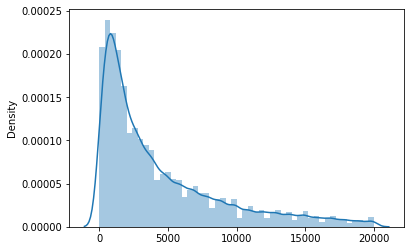

In [23]:
#Посмотрим на распределение целевого признака
sns.distplot(df.Price.values)
np.median(df.Price.values)

In [24]:
#Посмотрим сколько уникальных значений мы имеем в categorical признаках
categorical = ['Brand','Model','VehicleType','Gearbox','FuelType']
numerical_features_names = df.select_dtypes(include=['int64'])
df[categorical].nunique()

Brand           40
Model          250
VehicleType      8
Gearbox          2
FuelType         7
dtype: int64

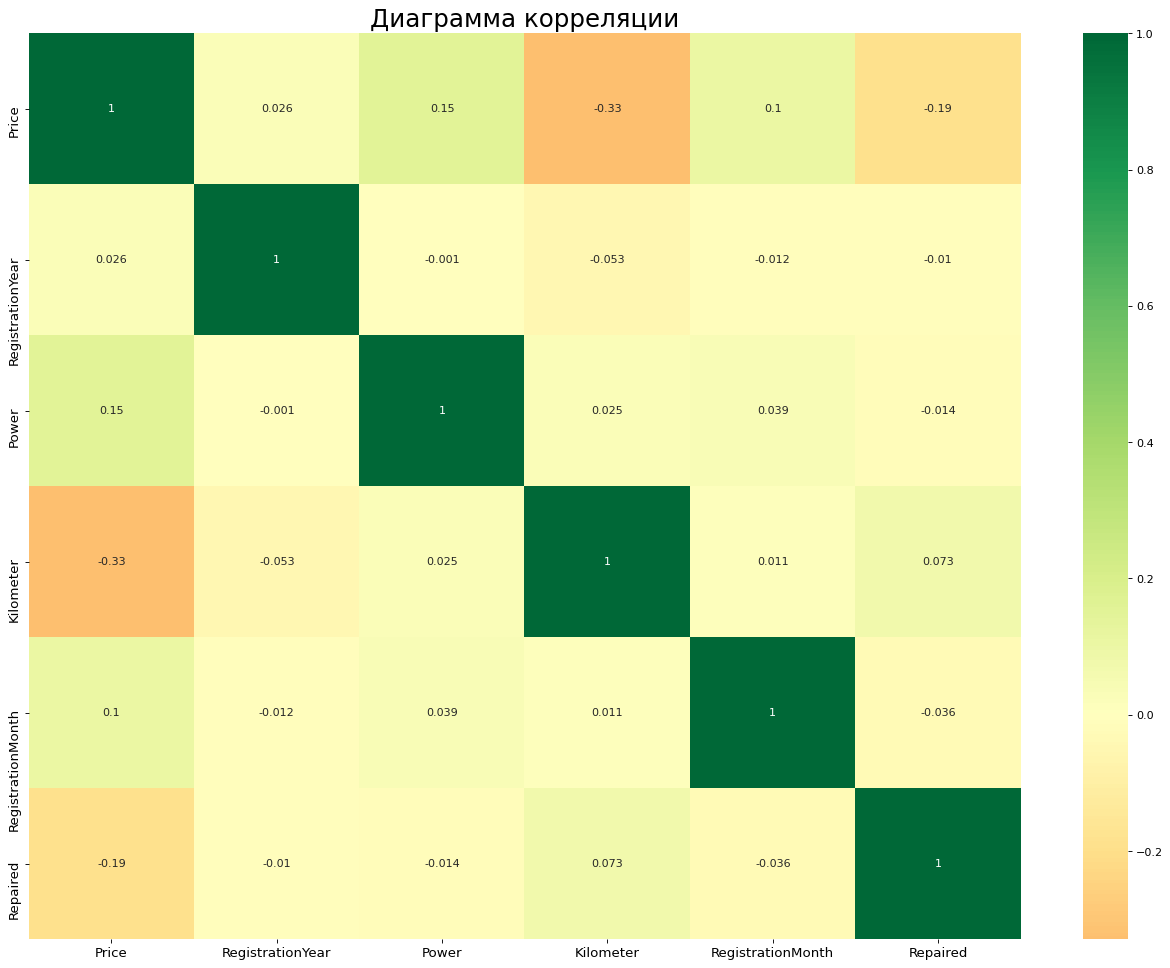

In [25]:
corr_diagram(df)

- Заменили пустые значения в столбцах model, brand, на имеющиеся значения с похожими значениями.
- Удалили дубликаты и пустые значения (подготовили датасет)
- Заменили nan в столбце Repaired на 0
- Удалили лишние столбцы

## Обучение моделей

Изучим 2 модели Градиентного бустинга : CatBoost, LightGBM и сравним с Линейной регрессией

In [26]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,480,small,1993,manual,0,golf,150000,0,petrol,volkswagen,0
1,18300,coupe,2011,manual,190,a5,125000,5,gasoline,audi,1
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,0
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,0
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,0


In [27]:
#Посмотрим сколько уникальных значений мы имеем в categorical признаках
categorical = ['VehicleType','Gearbox', 'Model','FuelType','Brand']
numerical_features_names = df.select_dtypes(include=['int64'])
df[categorical].nunique()

VehicleType      8
Gearbox          2
Model          250
FuelType         7
Brand           40
dtype: int64

In [28]:
#обе модели catboost и lightgbm поддерживают работу с категориальными данными 
#без перевода категориальных данных в номинальные
#Приведем категориальные признаки к формату category
df[categorical] = df[categorical].astype('category')
df['Repaired'] = df['Repaired'].astype('int64')

In [29]:
X_ = df.drop(['Price'],axis=1)
y_ = df['Price']

X__train, X__test, y__train, y__test = train_test_split(X_, y_, test_size=0.3, random_state=random_state)
#Размеры обучающей и тестовой выборки
print('Размер обучающей выборки с категориальными данными: {} объектов, {} признаков'.format(X__train.shape[0], X__train.shape[1]))
print('Размер тестовой выборки с категориальными данными: {} объектов, {} признаков'.format(X__test.shape[0], X__test.shape[1]))


Размер обучающей выборки с категориальными данными: 223697 объектов, 10 признаков
Размер тестовой выборки с категориальными данными: 95871 объектов, 10 признаков


OK - так и сделал.

<div class="alert alert-info">
<font size="4">🍕<b> Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Настоятельно тебе рекомендую рандом стейт (и другие глобальные константы) в начале работы сохранять в отдельную переменную и оперировать дальше ей. Иногда бывает нужно провести эксперимент с другим рандомом и менять по коду во всех местах где он испоьзуется явно хуже, чем одну переменную в начале поменять.

#### CatBoost

In [30]:
# Определим признаки и целевой признак 
X_ = df.drop(['Price'], axis=1)
y_ = df['Price']

In [31]:
# разделим датасет на обучающую и промежуточную выборки размеров 70 на 30
X_train, X_intermediate, y_train, y_intermediate = train_test_split(X_, y_, test_size=0.3, random_state=random_state)

# разделим промежуточную выборку на тестовую и валидационную выборки размеров 50 на 50
X_valid, X_test, y_valid, y_test = train_test_split(X_intermediate, y_intermediate, test_size=0.5, random_state=random_state)


In [32]:
# определим категориальные признаки
categorical = X_.select_dtypes(include='category').columns.tolist()

# создадим и обучим модель
model_cbr = CatBoostRegressor(cat_features=categorical, random_state=random_state, verbose=200)


start = time.time()
model_cbr.fit(X_train, y_train, eval_set=(X_valid, y_valid))

end = time.time()
catboost_time = end - start


Learning rate set to 0.119067
0:	learn: 4203.4616294	test: 4210.9126483	best: 4210.9126483 (0)	total: 397ms	remaining: 6m 36s
200:	learn: 1836.2247867	test: 1869.5896441	best: 1869.5896441 (200)	total: 41.2s	remaining: 2m 43s
400:	learn: 1777.0120613	test: 1832.2188096	best: 1832.2142266 (398)	total: 1m 22s	remaining: 2m 3s
600:	learn: 1742.8120767	test: 1814.9448037	best: 1814.9448037 (600)	total: 2m 1s	remaining: 1m 20s
800:	learn: 1718.6436155	test: 1806.7021028	best: 1806.7021028 (800)	total: 2m 46s	remaining: 41.5s
999:	learn: 1699.0421485	test: 1799.8644520	best: 1799.8644520 (999)	total: 3m 29s	remaining: 0us

bestTest = 1799.864452
bestIteration = 999



In [33]:
start = time.time()
# сделаем предсказание на валидационном наборе и рассчитаем RMSE
y_valid_pred = model_cbr.predict(X_valid)
end = time.time()
catboost_time_predicting = end - start

rmse_valid = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
print('Validation RMSE =', rmse_valid)

# # сделаем предсказание на тестовом наборе и рассчитаем RMSE
# y_test_pred = model_cbr.predict(X_test)
# rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
# print('Test RMSE =', rmse_test)

rmse_list = []
rmse_list.append(rmse_valid)
time_list = []
predicting_time = []
time_list.append(catboost_time)
predicting_time.append(catboost_time_predicting)

Validation RMSE = 1799.864451982122


готово

#### LightGBM

In [34]:
# функция вычисления RMSE
def rmse(predictions, targets): 
    return np.sqrt(((predictions - targets) ** 2).mean())


# Создаем экземпляр модели LGBMRegressor с фиксированным random_state для воспроизводимости
gbm = lgb.LGBMRegressor(random_state=random_state)


In [35]:
# Засекаем время начала обучения модели
start = time.time()

# Обучаем модель на тренировочных данных. 
# Мы также передаем тестовые данные для оценки производительности модели после каждой итерации.
gbm.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], eval_metric='rmse', categorical_feature=categorical)

# Засекаем время окончания обучения и вычисляем, сколько времени заняло обучение
end = time.time()
lightgbm_time = end - start


[1]	valid_0's rmse: 4217.37	valid_0's l2: 1.77862e+07
[2]	valid_0's rmse: 3939.65	valid_0's l2: 1.55208e+07
[3]	valid_0's rmse: 3696.99	valid_0's l2: 1.36677e+07
[4]	valid_0's rmse: 3486.06	valid_0's l2: 1.21526e+07
[5]	valid_0's rmse: 3298.49	valid_0's l2: 1.088e+07
[6]	valid_0's rmse: 3135.37	valid_0's l2: 9.83053e+06
[7]	valid_0's rmse: 2991.68	valid_0's l2: 8.95014e+06
[8]	valid_0's rmse: 2865.36	valid_0's l2: 8.21031e+06
[9]	valid_0's rmse: 2749.02	valid_0's l2: 7.55713e+06
[10]	valid_0's rmse: 2650.93	valid_0's l2: 7.02743e+06
[11]	valid_0's rmse: 2559.69	valid_0's l2: 6.55201e+06
[12]	valid_0's rmse: 2483.46	valid_0's l2: 6.1676e+06
[13]	valid_0's rmse: 2414.87	valid_0's l2: 5.8316e+06
[14]	valid_0's rmse: 2354.68	valid_0's l2: 5.5445e+06
[15]	valid_0's rmse: 2299.98	valid_0's l2: 5.28989e+06
[16]	valid_0's rmse: 2255.59	valid_0's l2: 5.08766e+06
[17]	valid_0's rmse: 2214.86	valid_0's l2: 4.90561e+06
[18]	valid_0's rmse: 2178.54	valid_0's l2: 4.74605e+06
[19]	valid_0's rmse: 214

In [36]:
# Теперь совершаем предсказания на валидационных данных.
start = time.time()
predictions_valid = gbm.predict(X_valid, num_iteration=gbm.best_iteration_)
end = time.time()
lightgbm_predicting_time_valid = end - start

# Вычисляем RMSE для тестовых и валидационных предсказаний
print('Validation RMSE =', rmse(predictions_valid, y_valid))

# Добавляем значения RMSE и времени в соответствующие списки
rmse_list.append(rmse(predictions_valid, y_valid))
predicting_time.append(lightgbm_predicting_time_valid)
time_list.append(lightgbm_time)


Validation RMSE = 1816.151587245965


In [37]:
# gbm = lgb.LGBMRegressor(random_state=random_state)

готово - расписал с комментариями по шагам

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
Молодец, что для моделей бустинга используешь встроенное кодирование, передаёшь список кат. признаков. Это чаще всего даёт лучший результат.

 #### RandomForestRegressor

In [38]:
# Опредлим признаки и целевой признак 
X = df.drop(['Price'], axis=1)
y = df['Price']

# разделим датасет на обучающую и промежуточную выборки размеров 70 на 30
X__train, X__intermediate, y__train, y__intermediate = train_test_split(X, y, test_size=0.3, random_state=random_state)

# разделим промежуточную выборку на тестовую и валидационную выборки размеров 50 на 50
X__valid, X__test, y__valid, y__test = train_test_split(X__intermediate, y__intermediate, test_size=0.5, random_state=random_state)

In [39]:
# Определим категориальные и числовые признаки
cat_columns = X.select_dtypes(include='category').columns
numeric_columns = ['RegistrationYear', 'Power', 'Kilometer']

In [40]:
# Создадим обработчик для категориальных признаков
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [41]:
# Создадим обработчик для числовых признаков
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])


In [42]:
# Применим ColumnTransformer для преобразования данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numeric_columns),
        ('cat', cat_transformer, cat_columns)])

# Объединим преобразователь и модель в один конвейер
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor(n_jobs=-1, random_state=random_state, max_depth=10, n_estimators = 10))])
start = time.time()

# Обучим модель
pipeline.fit(X__train, y__train)

end = time.time()
RFR_time = end - start

In [43]:
start = time.time()

# Предскажем цены на валидационном наборе
y__valid_pred = pipeline.predict(X__valid)

end = time.time()
RFR_predicting_time = end - start

# Рассчитаем RMSE
rmse_valid = np.sqrt(mean_squared_error(y__valid, y__valid_pred))
print('Validation RMSE =', rmse_valid)

rmse_list.append(rmse_valid)
predicting_time.append(RFR_predicting_time)
time_list.append(RFR_time)


Validation RMSE = 2082.8262239927003


Старый код удалил
1. создаю 3 выборки - тренировочную, валидационную, тестовую.
2. на тренировочной обучаю модели, на валидационной делаю предсказания, тестовую оставляем для тестов.
3. Вместо линейной модели использую Случайный лес.

## Анализ моделей

#### CatBoost + параметры

код ниже подбирает параметры для модели catboost - работает около двух часов, поэтому закомментировал

In [44]:
# # определяем пространство поиска
# space = {'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
#          'depth': hp.choice('depth', range(5, 16)),
#          'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10),
#          'iterations': hp.choice('iterations', range(100, 500))}

# def objective(space):
#     model = CatBoostRegressor(learning_rate=space['learning_rate'],
#                               depth=int(space['depth']),
#                               l2_leaf_reg=int(space['l2_leaf_reg']),
#                               iterations=int(space['iterations']),
#                               eval_metric='RMSE',
#                               cat_features=categorical,
#                               random_seed=random_state,
#                               verbose=False)
    
#     model.fit(X_train, y_train, eval_set=(X_valid, y_valid))
    
#     y_pred = model.predict(X_valid)
#     rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    
#     return {'loss': rmse, 'status': STATUS_OK }

# # запускаем поиск
# trials = Trials()
# best = fmin(fn=objective,
#             space=space,
#             algo=tpe.suggest,
#             max_evals=50,
#             trials=trials)

# print("Best: ", best)

<div class="alert alert-info">
<font size="4">🍕<b> Комментарий ревьюера V2</b></font>
    <br /> 
    <font size="3", color = "black">
        <b></b>

Ладно, ок, 2 часа - действительно многовато. Но вообще когда подбор гиперпараметров работает слишком долго, то есть смысл делать его с помощью <a href="https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html">RandomizedSearchCV</a>: с помощью параметра `n_iter` искать баланс между качеством найденных параметров и скоростью работы кода.

In [45]:
# подобранные параметры
best = {'depth': 8, 'iterations': 262, 'l2_leaf_reg': 2.2592332669811124, 'learning_rate': 0.11000895248305598}
best_loss = 1746.6795120279078

In [46]:
# Создание и обучение модели с оптимальными параметрами - сами параметры выше в словаре
model_cbr_optimized = CatBoostRegressor(learning_rate=best['learning_rate'],
                                        depth=best['depth'],
                                        l2_leaf_reg=best['l2_leaf_reg'],
                                        iterations=1000,
                                        cat_features=categorical,  
                                        random_seed=random_state,
                                        verbose=200)


In [47]:
start = time.time()

model_cbr_optimized.fit(X_train, y_train, eval_set=(X_valid, y_valid))

end = time.time()
catboost_optimized_time = end - start


start = time.time()

# Сделаем предсказание на валидационном наборе и рассчитаем RMSE
y_valid_pred = model_cbr_optimized.predict(X_valid)

end = time.time()
catboost_optimized_time_predicting = end - start


rmse_valid_optimized = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
print('Validation RMSE =', rmse_valid)

rmse_list.append(rmse_valid_optimized)
time_list.append(catboost_optimized_time)
predicting_time.append(catboost_optimized_time_predicting)


# # Сделаем предсказание на тестовом наборе и рассчитаем RMSE
# y_test_pred = model_cbr_optimized.predict(X_test)
# rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
# print('Test RMSE =', rmse_test)


0:	learn: 4204.5786161	test: 4212.0771522	best: 4212.0771522 (0)	total: 363ms	remaining: 6m 3s
200:	learn: 1766.9427520	test: 1832.3701109	best: 1832.3701109 (200)	total: 1m 4s	remaining: 4m 14s
400:	learn: 1694.1508032	test: 1801.3169337	best: 1801.3169337 (400)	total: 1m 58s	remaining: 2m 57s
600:	learn: 1649.8612956	test: 1789.7027941	best: 1789.6952704 (599)	total: 3m 3s	remaining: 2m 1s
800:	learn: 1615.1490144	test: 1782.9742979	best: 1782.9742979 (800)	total: 4m 5s	remaining: 1m
999:	learn: 1587.7541579	test: 1777.5607293	best: 1777.4103004 (992)	total: 5m 15s	remaining: 0us

bestTest = 1777.4103
bestIteration = 992

Shrink model to first 993 iterations.
Validation RMSE = 2082.8262239927003


#### LightGBM  + параметры

полный поиск по сетке работает довольно долго - ниже код, я его закомментировал. попробую рандомно подобрать параметры

In [48]:
# # Определим сетку параметров для поиска
# gridParams = {
#     'learning_rate': [0.005, 0.01, 0.03, 0.1],
#     'num_leaves': [20, 30, 40, 50],
#     'boosting_type' : ['gbdt'],
#     'objective' : ['regression'],
#     'max_depth' : [3, 4, 5, 6, 7, 8],
#     'random_state' : [random_state], 
#     'colsample_bytree' : [0.6, 0.7, 0.8, 0.9],
#     'subsample' : [0.6, 0.7, 0.8, 0.9],
#     'min_split_gain' : [0.01],
#     'min_data_in_leaf':[10]
#     }
# # Создаем объект модели
# lgbm = lgb.LGBMRegressor()

# # Создаем объект GridSearchCV
# grid = GridSearchCV(lgbm, gridParams, verbose=2, cv=5, scoring='neg_mean_squared_error')

# # Обучаем модель
# grid.fit(X_train, y_train)

# # Выводим лучшие параметры
# print("Best parameters found by grid search are: ", grid.best_params_)


In [53]:
# Определим сетку параметров для поиска
param_dist = {
    'learning_rate': [0.005, 0.01, 0.03, 0.1],
    'num_leaves': [20, 30, 40, 50],
    'boosting_type' : ['gbdt'],
    'objective' : ['regression'],
    'max_depth' : [3, 4, 5, 6, 7, 8],
    'random_state' : [random_state], 
    'colsample_bytree' : [0.6, 0.7, 0.8, 0.9],
    'subsample' : [0.6, 0.7, 0.8, 0.9],
    'min_split_gain' : [0.01],
    'min_data_in_leaf':[10]
    }

# Создаем объект модели
lgbm_optimized = lgb.LGBMRegressor()

# Создаем объект RandomizedSearchCV
random_search = RandomizedSearchCV(lgbm_optimized,
                                   param_distributions=param_dist,
                                   n_iter=2,
                                   scoring='neg_mean_squared_error',
                                   cv=5,
                                   verbose=2,
                                   n_jobs=-1)

# Обучаем модель
random_search.fit(X_train, y_train)


# Выводим лучшие параметры
print("Best parameters found by random search are: ", random_search.best_params_)

# Создаем экземпляр модели LGBMRegressor с лучшими параметрами
lgbm_optimized = lgb.LGBMRegressor(**random_search.best_params_)

# Засекаем время начала обучения модели
start = time.time()

# Обучаем модель на тренировочных данных. 
lgbm_optimized.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], early_stopping_rounds=100, eval_metric='rmse', categorical_feature=categorical)

# Засекаем время окончания обучения и вычисляем, сколько времени заняло обучение
end = time.time()
lightgbm_optimized_time = end - start



Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] END boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.01, max_depth=8, min_data_in_leaf=10, min_split_gain=0.01, num_leaves=40, objective=regression, random_state=42, subsample=0.9; total time=13.7min
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.01, max_depth=8, min_data_in_leaf=10, min_split_gain=0.01, num_leaves=40, objective=regression, random_state=42, subsample=0.9; total time=18.9min
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[CV] END boosting_type=gbdt, colsample_bytree=0.8, learning_rate=0.01, max_depth=8, min_data_in_leaf=10, min_split_gain=0.01, num_leaves=40, objective=regression, random_state=42, subsample=0.9; total time=28.5min
[LightGBM] [Warning] min_data_in_leaf is set=10, min_c

In [54]:
# Теперь совершаем предсказания на валидационных данных.
start = time.time()
predictions_valid = lgbm_optimized.predict(X_valid, num_iteration=lgbm_optimized.best_iteration_)
end = time.time()
lightgbm_optimized_predicting_time_valid = end - start

# Вычисляем RMSE для тестовых и валидационных предсказаний
print('Validation RMSE =', rmse(predictions_valid, y_valid))

# Добавляем значения RMSE и времени в соответствующие списки
rmse_list.append(rmse(predictions_valid, y_valid))
predicting_time.append(lightgbm_optimized_predicting_time_valid)
time_list.append(lightgbm_optimized_time)


Validation RMSE = 1972.3197783371108


In [55]:
# # Гиперпараметры
# param_dist = {
#     'regressor__n_estimators': [10, 50, 100, 200],
#     'regressor__max_depth': [None, 10, 20, 30, 40],
#     'regressor__min_samples_split': [2, 5, 10],
#     'regressor__min_samples_leaf': [1, 2, 4],
#     'regressor__max_features': ['auto', 'sqrt']
# }

# # Экземпляр RandomizedSearchCV
# random_search = RandomizedSearchCV(pipeline, param_distributions=param_dist, n_iter=20, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, random_state=random_state)

# # Засекаем время начала подбора гиперпараметров
# start = time.time()

# # Случайный поиск гиперпараметров
# random_search.fit(X__train, y__train)

# # Засекаем время окончания подбора гиперпараметров и вычисляем, сколько времени заняло обучение
# end = time.time()
# RFR_time_optimized = end - start

# # Получите лучшие гиперпараметры
# best_params = random_search.best_params_
# print("Best parameters: ", best_params)

# # Модель с использованием лучших гиперпараметров
# pipeline.set_params(**best_params)

# start = time.time()

# # Предскажем цены на валидационном наборе
# y__valid_pred = pipeline.predict(X__valid)

# end = time.time()
# RFR_predicting_time_optimized = end - start

# # Рассчитаем RMSE
# rmse_valid = np.sqrt(mean_squared_error(y__valid, y__valid_pred))
# print('Validation RMSE =', rmse_valid)

# rmse_list.append(rmse_valid)
# predicting_time.append(RFR_predicting_time_optimized)
# time_list.append(RFR_time_optimized)


In [56]:
results_df = pd.DataFrame(data=[rmse_list, time_list, predicting_time], columns=['CatBoost default','LightGBM default','RandomForestRegressor default','CatBoost+Params','LightGBM+Params'], 
                          index=['RMSE','Learning Time','Predicting Time'])


In [57]:
results_df

,CatBoost default,LightGBM default,RandomForestRegressor default,CatBoost+Params,LightGBM+Params
RMSE,1799.864452,1816.151587,2082.826224,1777.410300,1972.319778
Learning Time,214.504139,1070.435194,24.140352,322.302274,7.501052
Predicting Time,0.309132,0.582889,0.106959,0.616435,0.350928


In [58]:
# Сделаем предсказание моделью CatBoost+Params на тестовом наборе и рассчитаем RMSE
y_test_pred = model_cbr_optimized.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
print('Test RMSE =', rmse_test)

Test RMSE = 1766.6107950693354


<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера V2</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
Тестируется только лучшая модель, всё корректно 👍

<div class="alert alert-success">
<font size="4"><b>✔️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />    
Сравнительная табличка - хороший вариант наглядной демонстрации итоговых результатов

Выводы
- Лучший RSME дефолтной модели показал CatBoost+Params, у LightGBM+Params также удалось немного улучшить по сравнению с дефолтной моделью;
- После подбора параметров, удалось снизить  RMSE у CatBoost+Params и у LightGBM+Params.
- на тестовой выборке модель CatBoost+Params показала RMSE = 1777


<div class="alert alert-info">
<font size="4">🍕<b> Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Подведём итоги. В целом, работа весьма неплохая. В плане кодирования так вообще порадовал. Но причины доработать проект всё-таки есть:

+ Поправить вычисление переменной `features`

+ Пояснить логику работы функции `impute_value`

+ Зафиксировать рандом стейт для моделей бустинга

+ Небольшой подбор гиперпараметров для бустинга

+ Привести в порядок пайплайн работы: валидация (одинаковая для всех моделей) + тестирование в конце работы только для одной модели - которая показала себя лучше всех на валидации

+ Не использовать LabelEncoder для признаков т.к. он создан для кодирования таргета

+ Не использовать линейные модели с порядковым кодированием

В целом, кажется, не очень мало, но и сложного ничего нет. Так что жду новую отправку с надеждой, что она будет для тебя последней на данном проекте!

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей